# Introduction

This notebook contains my attempts to use the Surprise library to build a book recommendation system through a process called collaborative filtering. 

## Prerequisites
Before diving into building a recommendation system using the Surprise library, it's important to have some familiarity with Python programming and data manipulation techniques. Additionally, a basic understanding of collaborative filtering and recommendation systems is helpful. However I did try to provide explainations where I thought necessary. 

## Article
I provide a brief explaination of some recommender system concepts below, but I do have an article for you to read on [medium]().

## Collaborative Filtering
Collaborative filtering is a technique used in recommendation systems that involves predicting a user's preferences based on the preferences of other users who have similar behavior or preferences. It involves finding similarities between users or items based on their interactions with the system.

### Content-based Filtering
To be clear, no content-based filtering is used in this notebook. However, it is important to understand the distinction between the two. Both approaches have advantages and limitations and are frequently used in tandem to create more effective recommendation systems.

Content-based filtering is a strategy that recommends products based on their content that are comparable to those that a user has previously enjoyed. It uses information about the qualities or features of items, such as a book's genre, author, or plot, to find other items with similar content.

The main difference between collaborative filtering and content-based filtering is the type of data used to make recommendations. Collaborative filtering relies on user interactions and preferences, while content-based filtering relies on item attributes and features. Both approaches have their advantages and disadvantages and are often used together to build more effective recommendation systems.

## Surprise
Surprise is a Python library designed for building and analyzing recommender systems. It provides a range of algorithms for collaborative filtering, including matrix factorization-based methods, k-NN, and SVD. Surprise does not provide algorithms for content-based filtering. 

## The Data
In this notebook, I used a dataset containing information about books and their ratings from the Goodreads website. The dataset contains information such as book title, author, and user ratings. You will gain a better understanding of the data in the EDA section. 



# Installs and imports


The code begins by installing the "surprise" package using the pip package manager. It then imports several modules, including "files" and "os" from the "google.colab" package, and "pandas", "matplotlib.pyplot", and "defaultdict" from their respective packages. The "drive" module is imported from "google.colab" and used to mount the user's Google Drive to the current Python environment. Finally, several modules are imported from the "surprise" package, including "Dataset", "Reader", "SVD", "accuracy", "KNNBaseline", and "get_dataset_dir", as well as "train_test_split" from the "surprise.model_selection" subpackage. These modules provide tools for building and evaluating recommender systems.

In [ ]:
# If running in google colab
# Mount your Google Drive
# This is so we can save the trained model in your drive later
from google.colab import drive, files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import networkx as nx
from collections import defaultdict
from surprise import Dataset, Reader, SVD, accuracy, KNNBaseline, get_dataset_dir
from surprise.model_selection import train_test_split

# EDA

Exploratory Data Analysis (EDA) is a critical step in data analysis that involves examining and visualizing data to gain insights and discover patterns, trends, relationships, anomalies, and other important characteristics of the data. I find it useful in familiarizing myself with the dataset. 

For the majority of this project, I will be working with the ratings file. The books file contains useful metadata which will be used to display comprehensive recommendations. 


## Getting Started

In [ ]:
# Load the ratings data in panda dataframe
ratings_df = pd.read_csv('ratings2.csv')

# Load the books data in panda dataframe
books_df = pd.read_csv('books2.csv')

In [ ]:
# set display options
pd.set_option('display.max_columns', None) # display all columns
pd.set_option('display.width', 1000) # set display width

In [ ]:
print(ratings_df.head())

   user_id  book_id  rating
0        1      258       5
1        2     4081       4
2        2      260       5
3        2     9296       5
4        2     2318       3


In [ ]:
print(ratings_df.sort_values('book_id'))

         user_id  book_id  rating
2174136    29300        1       4
433265      6590        1       3
1907014     7546        1       5
3743260    43484        1       1
1266846    18689        1       5
...          ...      ...     ...
2366366    31293    10000       3
3376022    12272    10000       4
2811513    35330    10000       4
4134364    46337    10000       5
4047777    42537    10000       4

[5976479 rows x 3 columns]


In [ ]:
print(books_df.head())

   book_id  goodreads_book_id  best_book_id  work_id  books_count       isbn        isbn13                      authors  original_publication_year                            original_title                                              title language_code  average_rating  ratings_count  work_ratings_count  work_text_reviews_count  ratings_1  ratings_2  ratings_3  ratings_4  ratings_5                                          image_url                                    small_image_url
0        1            2767052       2767052  2792775          272  439023483  9.780439e+12              Suzanne Collins                     2008.0                          The Hunger Games            The Hunger Games (The Hunger Games, #1)           eng            4.34        4780653             4942365                   155254      66715     127936     560092    1481305    2706317  https://images.gr-assets.com/books/1447303603m...  https://images.gr-assets.com/books/1447303603s...
1        2                

In [ ]:
print(books_df.sort_values('book_id'))

      book_id  goodreads_book_id  best_book_id   work_id  books_count        isbn        isbn13                      authors  original_publication_year                                     original_title                                              title language_code  average_rating  ratings_count  work_ratings_count  work_text_reviews_count  ratings_1  ratings_2  ratings_3  ratings_4  ratings_5                                          image_url                                    small_image_url
0           1            2767052       2767052   2792775          272   439023483  9.780439e+12              Suzanne Collins                     2008.0                                   The Hunger Games            The Hunger Games (The Hunger Games, #1)           eng            4.34        4780653             4942365                   155254      66715     127936     560092    1481305    2706317  https://images.gr-assets.com/books/1447303603m...  https://images.gr-assets.com/books/1447303603s..

In [ ]:
# Print dataset size and examine column data types
print("Number of ratings: ", len(ratings_df))
print(ratings_df.info())

Number of ratings:  5976479
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5976479 entries, 0 to 5976478
Data columns (total 3 columns):
 #   Column   Dtype
---  ------   -----
 0   user_id  int64
 1   book_id  int64
 2   rating   int64
dtypes: int64(3)
memory usage: 136.8 MB
None


In [ ]:
print("Number of books: ", len(books_df))
print(ratings_df.info())

Number of books:  10000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5976479 entries, 0 to 5976478
Data columns (total 3 columns):
 #   Column   Dtype
---  ------   -----
 0   user_id  int64
 1   book_id  int64
 2   rating   int64
dtypes: int64(3)
memory usage: 136.8 MB
None


In [ ]:
# Check for missing values in the dataframe
ratings_df.isnull().sum()

user_id    0
book_id    0
rating     0
dtype: int64

In [ ]:
# Distribution of ratings
print(ratings_df['rating'].value_counts())

4    2139018
5    1983093
3    1370916
2     359257
1     124195
Name: rating, dtype: int64


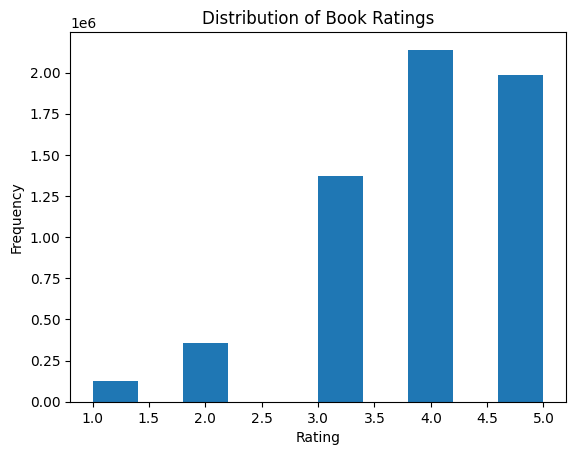

In [ ]:
# Create a histogram of the ratings
plt.hist(ratings_df['rating'])
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Book Ratings')
plt.show()

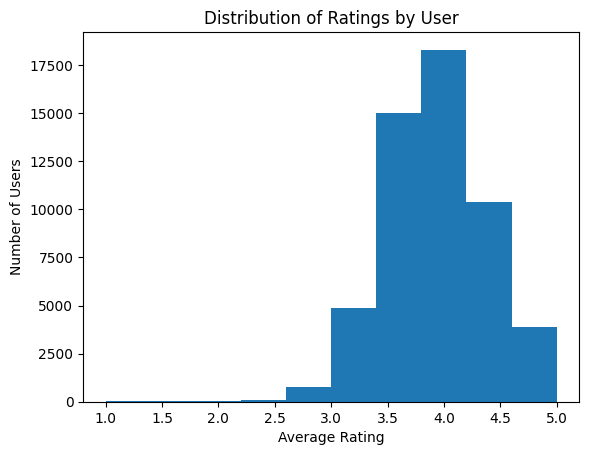

In [ ]:
# Group the data by user ID and calculate the mean rating for each user
user_ratings = ratings_df.groupby('user_id')['rating'].mean()

# Plot a histogram of the user ratings
plt.hist(user_ratings, bins=10)
plt.title('Distribution of Ratings by User')
plt.xlabel('Average Rating')
plt.ylabel('Number of Users')
plt.show()

In [ ]:
ratings_df['rating'].describe()

count    5.976479e+06
mean     3.919866e+00
std      9.910868e-01
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

In [ ]:
ratings_df.groupby('book_id')['rating'].mean()

book_id
1        4.279707
2        4.351350
3        3.214341
4        4.329369
5        3.772224
           ...   
9996     4.014184
9997     4.451613
9998     4.323529
9999     3.707692
10000    4.009009
Name: rating, Length: 10000, dtype: float64

In [ ]:
ratings_df.corr()

,user_id,book_id,rating
user_id,1.000000,0.015235,0.077870
book_id,0.015235,1.000000,-0.015414
rating,0.077870,-0.015414,1.000000


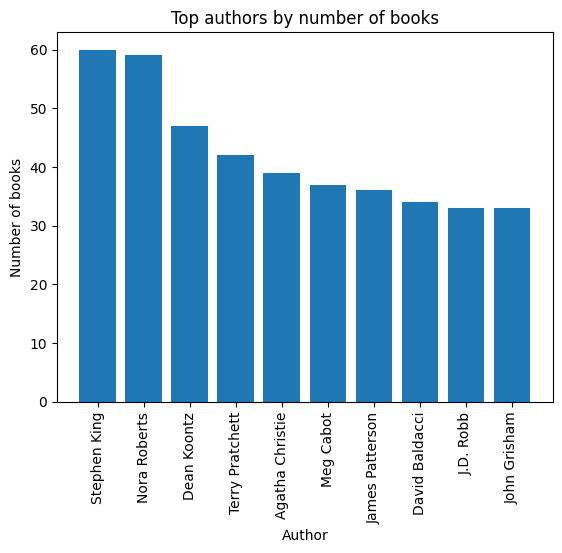

In [ ]:
# Count the number of books by each author
author_counts = books_df['authors'].value_counts()

# Get the top 10 authors by the number of books
top_authors = author_counts.head(10)

# Plot a bar chart of the top authors
plt.bar(top_authors.index, top_authors.values)
plt.xticks(rotation=90)
plt.xlabel('Author')
plt.ylabel('Number of books')
plt.title('Top authors by number of books')
plt.show()

For collaborative filtering models, only the user-item ratings matrix is typically required. 

While the merged and trimmed dataframe is useful for visualization purposes, it will not be used for collaborative filtering modeling, as it is not necessary to include book metadata in the model. Instead, the user-item ratings matrix will be used directly to train the collaborative filtering model.

In [ ]:
# Merge the two dataframes on 'book_id'
merged_df = pd.merge(ratings_df, books_df, on='book_id')

# drop unnecessary columns
merged_df.drop(["goodreads_book_id", "best_book_id", "work_id", "books_count", "isbn", "isbn13", 
                "work_ratings_count",  "work_text_reviews_count",  "ratings_1",  "ratings_2",  "ratings_3",  "ratings_4",  "ratings_5",
                "language_code"], axis=1, inplace=True)

In [ ]:
print(len(merged_df))

5976479


In [ ]:
print(merged_df.head())

   user_id  book_id  rating                          authors  original_publication_year        original_title                                              title  average_rating  ratings_count                                          image_url                                    small_image_url
0        1      258       5  Carlos Ruiz Zafón, Lucia Graves                     2001.0  La sombra del viento  The Shadow of the Wind (The Cemetery of Forgot...            4.24         263685  https://images.gr-assets.com/books/1344545047m...  https://images.gr-assets.com/books/1344545047s...
1       11      258       3  Carlos Ruiz Zafón, Lucia Graves                     2001.0  La sombra del viento  The Shadow of the Wind (The Cemetery of Forgot...            4.24         263685  https://images.gr-assets.com/books/1344545047m...  https://images.gr-assets.com/books/1344545047s...
2      143      258       4  Carlos Ruiz Zafón, Lucia Graves                     2001.0  La sombra del viento  The Sha

## Wordcloud


Wordcloud is a Python library used for generating visual representations of text data. It is particularly useful for creating word clouds, which are visualizations that represent the most frequent words in a text document or corpus as larger and bolder words.

This code generates a word cloud of the book titles in the books_df dataframe. The resulting plot shows a visual representation of the most common words in the book titles, with the size of each word representing its frequency.

By using the merged_df we can create a cool visualization of the most popular book titles. 

the hunger games the hunger games 1 harry potter and the sorcerers stone harry potter 1 twilight twilight 1 to kill a mockingbird the great gatsby the fault in our stars the hobbit the catcher in the rye angels demons robert langdon 1 pride and prejudice the kite runner divergent divergent 1 1984 animal farm the diary of a young girl the girl with the dragon tattoo millennium 1 catching fire the hunger games 2 harry potter and the prisoner of azkaban harry potter 3 the fellowship of the ring the lord of the rings 1 mockingjay the hunger games 3 harry potter and the order of the phoenix harry potter 5 the lovely bones harry potter and the chamber of secrets harry potter 2 harry potter and the goblet of fire harry potter 4 harry potter and the deathly hallows harry potter 7 the da vinci code robert langdon 2 harry potter and the halfblood prince harry potter 6 lord of the flies romeo and juliet gone girl the help of mice and men memoirs of a geisha fifty shades of grey fifty shades 1 the

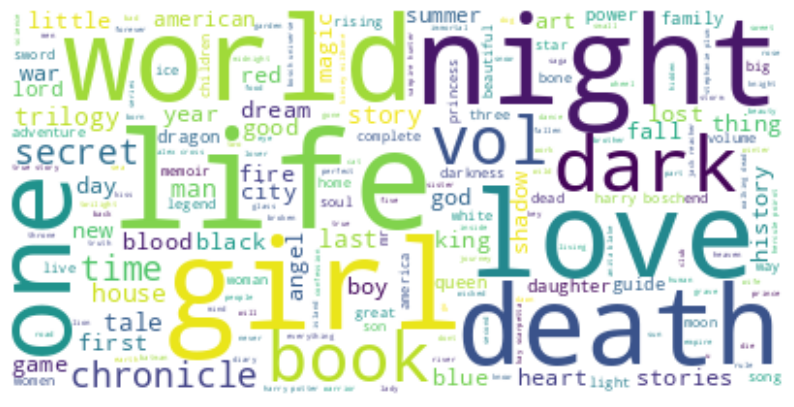

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import re

# Combine all the book titles into a single string
text = ' '.join(books_df['title'].astype(str))

# Preprocess the text data
processed_text = re.sub(r'[^\w\s]', '', text.lower())
processed_text = re.sub(r'[^\w\s]', '', processed_text)
processed_text = re.sub('\s+', ' ', processed_text)

# Create a word cloud
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color='white').generate(processed_text)

# Plot the word cloud
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Note: You may get a notification that the data rate has been exceed for the next cell. That is fine, let the cell finish running. 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



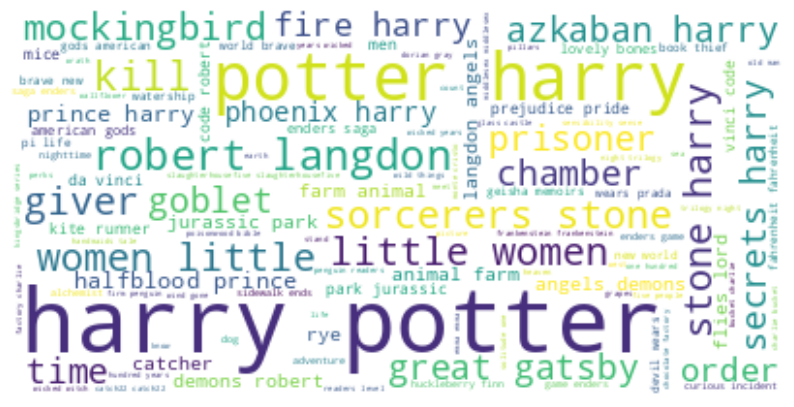

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import re

# Combine all the book titles into a single string
# use first 1000000 in the df to speed up this cell
text = ' '.join(merged_df['title'].astype(str)[:1000000])

# Preprocess the text data
processed_text = re.sub(r'[^\w\s]', '', text.lower())
processed_text = re.sub(r'[^\w\s]', '', processed_text)
processed_text = re.sub('\s+', ' ', processed_text)

# Create a word cloud
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color='white').generate(processed_text)

# Plot the word cloud
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## networkx

The book-book co-occurrence network is a powerful tool for understanding the relationships between books based on how often they are read by the same user. The network consists of nodes and edges, where each node represents a book, and an edge between two nodes indicates that these two books were read by the same user. The thickness of the line between two nodes represents the co-occurrence frequency, which is a measure of how often the two books were read together by the same user. In other words, if a user has rated one book, the likelihood of finding the other book in the same section is higher.

This network can provide valuable insights into which books are commonly read together and can be used for various purposes, such as book recommendations or identifying similar books. For example, if two books have a high co-occurrence frequency, it may suggest that they are similar in terms of genre, writing style, or subject matter, and may be recommended to users who have read one of these books.

In the example provided, the dataframe was filtered to include only the first 1000 books published after the year 2000.

Based on the results of this graph, we can make several assumptions about the reading preferences of users who have rated books in this dataset.

Firstly, we can see that there are groups of books that are frequently rated together, forming clusters in the network. This suggests that users who have rated books in one cluster may be more likely to enjoy books in the same cluster, indicating that the books in a particular cluster share some common characteristics, such as genre or writing style.

Secondly, we can observe that some books are more frequently rated together than others. For example, we can see that the book "The Da Vinci Code" is connected to several other books with thick edges, indicating that it is frequently rated together with these books. This suggests that users who have read "The Da Vinci Code" may also enjoy these other books and vice versa.

Overall, this graph provides us with insights into the relationships between books based on user ratings, which can be useful for making personalized recommendations to users and understanding their reading preferences.

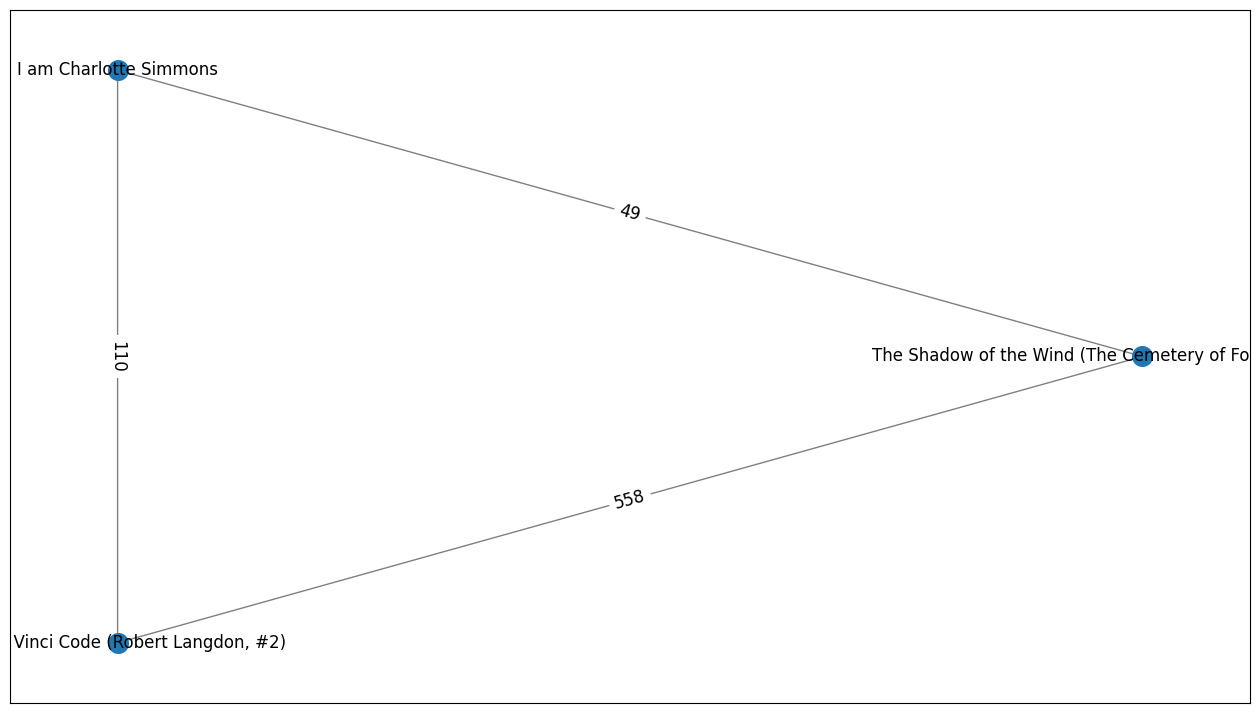

In [ ]:
# Filter the data to books published after 2000
network_df = merged_df[merged_df['original_publication_year'] > 2000]
network_df = network_df[:10000]
# Create a co-occurrence matrix
books = network_df['title'].unique()

co_occurrence = pd.DataFrame(index=books, columns=books).fillna(0)

for user in network_df['user_id'].unique():
    titles = network_df[network_df['user_id'] == user]['title'].unique()
    for i in range(len(titles)):
        for j in range(i+1, len(titles)):
            co_occurrence.loc[titles[i], titles[j]] += 1
            co_occurrence.loc[titles[j], titles[i]] += 1

# Create a networkx graph
G = nx.from_pandas_adjacency(co_occurrence)

# Plot the graph
# Try different layouts 
# pos = nx.spring_layout(G, k=0.5)
# pos = nx.kamada_kawai_layout(G)
pos = nx.circular_layout(G)

plt.figure(figsize=(16, 9))

# Draw the nodes
nx.draw_networkx_nodes(G, pos, node_size=200)

# Draw the edges with labels for frequency of co-occurrence
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12)

# Draw the node labels
node_labels = {book: book for book in books}
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=12)

plt.show()

# Build the Model

Alright, now that we are more familiar with the data we can train a prediction model and build our recommendation system!

First we will train the model. We will use a subset of the original data for demo purposes. Building an "anti-testset" on the full dataset will crash the session if you are on colab.


In [ ]:
# Take a subset of the df so it runs faster, you might have to take an even smaller subset
subset = ratings_df.sample(n=10000, random_state=42)

# Define the reader object for Surprise
reader = Reader(rating_scale=(1, 5))

# Load the merged dataframe into Surprise's Dataset object
data = Dataset.load_from_df(subset[['user_id', 'book_id', 'rating']], reader)

# Split the dataset
trainset, testset = train_test_split(data, test_size=0.2)

# Instantiate the algorithm
algo = SVD()

# Train the model
algo.fit(trainset)

The following function [get_top_n](https://surprise.readthedocs.io/en/stable/FAQ.html#how-to-get-the-top-n-recommendations-for-each-user) was provided in the surprise documentation. 

In [ ]:
def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

Using the [build_anti_testset](https://surprise.readthedocs.io/en/stable/trainset.html?highlight=build_anti_testset#surprise.Trainset.build_anti_testset) method from surprise, we build a test set of books that the users have not rated. 



In [ ]:
# Than predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

top_n = get_top_n(predictions, n=10)
top_n

**What is RMSE?**

RMSE stands for Root Mean Squared Error. It is a metric commonly used to evaluate the accuracy of a predictive model, particularly in regression analysis. RMSE measures the difference between the actual values and the predicted values of a variable, taking into account the square of the differences.

A lower RMSE indicates a better fit of the model to the data, as it means that the difference between the actual and predicted values is smaller.

In [ ]:
rmse = accuracy.rmse(predictions)

RMSE: 0.1758


In [ ]:
predictions[:5]

[Prediction(uid=9204, iid=538, r_ui=3.926375, est=3.9358696906741235, details={'was_impossible': False}),
 Prediction(uid=9204, iid=828, r_ui=3.926375, est=4.025387128881237, details={'was_impossible': False}),
 Prediction(uid=9204, iid=1403, r_ui=3.926375, est=4.057938095168291, details={'was_impossible': False}),
 Prediction(uid=9204, iid=1574, r_ui=3.926375, est=3.8116468994466706, details={'was_impossible': False}),
 Prediction(uid=9204, iid=106, r_ui=3.926375, est=4.037866531900072, details={'was_impossible': False})]

While it's certainly useful to know the book ID, it may not be the most helpful recommendation on its own. So, let's jazz things up a bit and create a user-friendly map to help us easily locate and print the titles of those recommended books!

In [ ]:
# Map book_id to book title
id_to_title = dict(zip(books_df['book_id'], books_df['title']))

In [ ]:
# Print the first 5 items in id_to_title
count = 0
for book_id, book_title in id_to_title.items():
    print(f'{book_id}: {book_title}')
    count += 1
    if count == 5:
        break

1: The Hunger Games (The Hunger Games, #1)
2: Harry Potter and the Sorcerer's Stone (Harry Potter, #1)
3: Twilight (Twilight, #1)
4: To Kill a Mockingbird
5: The Great Gatsby


In [ ]:
# Print the recommended items for each user
for uid, user_ratings in list(top_n.items())[:5]:
    print(uid, [iid for (iid, _) in user_ratings])

9204 [2, 188, 24, 89, 102, 4, 168, 43, 31, 25]
14927 [43, 2, 161, 25, 31, 89, 23, 2746, 512, 168]
4269 [43, 161, 102, 4, 25, 222, 2064, 31, 464, 2]
3901 [43, 31, 89, 125, 512, 27, 168, 102, 21, 250]
50025 [31, 43, 27, 222, 15, 89, 125, 644, 25, 463]


In [ ]:
# Print the recommended items and their rating estimations for 5 users
for uid, user_ratings in list(top_n.items())[:5]:
    print(f"Test subject {uid}, I have carefully considered your preferences. I believe you would like the following books:")
    for (iid, rating) in user_ratings:
        print("- {} (rating: {:.2f})".format(id_to_title[iid], rating))
    print()

Test subject 9204, I have carefully considered your preferences. I believe you would like the following books:
- Harry Potter and the Sorcerer's Stone (Harry Potter, #1) (rating: 4.59)
- A Dance with Dragons (A Song of Ice and Fire, #5) (rating: 4.56)
- Harry Potter and the Goblet of Fire (Harry Potter, #4) (rating: 4.55)
- The Princess Bride  (rating: 4.54)
- Where the Wild Things Are (rating: 4.53)
- To Kill a Mockingbird (rating: 4.52)
- The Stand (rating: 4.52)
- Jane Eyre (rating: 4.49)
- The Help (rating: 4.49)
- Harry Potter and the Deathly Hallows (Harry Potter, #7) (rating: 4.48)

Test subject 14927, I have carefully considered your preferences. I believe you would like the following books:
- Jane Eyre (rating: 4.64)
- Harry Potter and the Sorcerer's Stone (Harry Potter, #1) (rating: 4.55)
- The Return of the King (The Lord of the Rings, #3) (rating: 4.48)
- Harry Potter and the Deathly Hallows (Harry Potter, #7) (rating: 4.46)
- The Help (rating: 4.44)
- The Princess Bride  (

## Have Fun

As an attentive data analyst (and one that isn't always 100% sure whats going on), I wanted to double-check that the predicted ratings we're looking at are, in fact, the model's predictions, not the user's actual ratings.

To get started, simply run the cell and enter a user ID, and voila! You'll receive a list of the top 5 recommended books, complete with their predicted ratings for that user.

But we don't stop there! In the next cell, you'll find a delightful dataset containing the user's actual book ratings. That way, you can make a quick comparison and confirm that the predicted ratings are, indeed, for books they haven't already rated.

***feel free to correct me, and inform me of better methods***

In [ ]:
print("Choose a user id from above")
test_subject = int(input("input a user id: "))
print(f"Welcome, test subject {test_subject}")

Choose a user id from above
input a user id: 50025
Welcome, test subject 50025


In [ ]:
user_predictions = [pred for pred in predictions if pred.uid == test_subject]

print(f"Hello test subject {test_subject}, I calculated your you preferences based on your previous ratings. Here is a sample:")
for pred in user_predictions[:5]:
    item_id = pred.iid
    item_title = books_df.loc[books_df['book_id'] == item_id, 'title'].iloc[0]
    print(f"For item number {item_id}, titled '{item_title}' your predicted rating is", pred.est)

Hello test subject 50025, I calculated your you preferences based on your previous ratings. Here is a sample:
For item number 1263, titled 'Leviathan Wakes (The Expanse, #1)' your predicted rating is 4.167515668918434
For item number 1014, titled 'So Long, and Thanks for All the Fish (Hitchhiker's Guide to the Galaxy, #4)' your predicted rating is 3.696454829586925
For item number 5956, titled 'Broken Homes (Peter Grant, #4)' your predicted rating is 4.310434209861933
For item number 7, titled 'The Hobbit' your predicted rating is 4.269986828475517
For item number 1394, titled 'White Night (The Dresden Files, #9)' your predicted rating is 4.777673697249522


In [ ]:
subset_df = merged_df[merged_df['user_id'] == test_subject]
print(f"test subject {test_subject}, you have rated {len(subset_df)} books!")
if subset_df.empty:
    print(f"test subject {test_subject} has no previous ratings.")
else:
    print(f"test subject {test_subject}, these are your previously rated books: ")
    print(subset_df[['title', 'rating']])

test subject 50025, you have rated 127 books!
test subject 50025, these are your previously rated books: 
                                                     title  rating
714081                                        Nine Stories       3
744375   Freakonomics: A Rogue Economist Explores the H...       4
870613                                          Snow Crash       3
871915                                       Cryptonomicon       4
905461                 Quicksilver (The Baroque Cycle, #1)       3
...                                                    ...     ...
5610833                                             Armada       5
5680295    The Aeronaut's Windlass (The Cinder Spires, #1)       4
5770198                                             Rogues       4
5782099                  Foxglove Summer (Peter Grant, #5)       4
5872850                                          Seveneves       4

[127 rows x 2 columns]


In [ ]:
book_title = input("Enter a book title to check if it's previously rated by the user: ")

subset_df = merged_df[(merged_df['user_id'] == test_subject) & (merged_df['title'] == book_title)]
if subset_df.empty:
    print(f"{book_title} is not previously rated by test subject {test_subject}.")
else:
    print(f"{book_title} is previously rated by test subject {test_subject} with a rating of {subset_df['rating'].iloc[0]}.")

Enter a book title to check if it's previously rated by the user: The Alchemist
The Alchemist is not previously rated by test subject 50025.


This code takes user input for a book title and maps it to a corresponding book_id based on a list of available books' titles. The collaborative filtering algorithm is then used to fetch the prediction for the entered book_id and the current "test subject". Finally, the program prints the predicted rating the test subject would leave for the entered book title.

In [ ]:
# Get book_id from user input
book_title = input("Enter a book title: ")
while book_title not in id_to_title.values():
    print("Invalid book title. Please try again.")
    book_title = input("Enter a book title: ")
book_id = next(key for key, value in id_to_title.items() if value == book_title)

# Get prediction for book_id
prediction = algo.predict(test_subject, book_id)
print(f"Predicted rating for '{book_title}' by test subject {test_subject} is {prediction.est:.3f}")

Enter a book title: The Alchemist
Predicted rating for 'The Alchemist' by test subject 50025 is 3.642


# Precision and Recall

This code is used to calculate precision and recall, and is provided in the Surprise documentation. Precision measures the proportion of recommended items that are relevant to the user, while recall measures the proportion of relevant items that are recommended to the user. The code uses a given threshold to determine if an item is considered relevant or recommended. An item is considered relevant if its true rating is greater than the threshold, and an item is considered recommended if its estimated rating is greater than the threshold and if it is among the k highest estimated ratings.

In k-fold cross-validation, the dataset is divided into k subsets, and the algorithm is trained and tested k times on different subsets of the data. In each iteration, the precision and recall are computed for each user in the test set, and then averaged over all users to get the average precision and recall for that iteration. Therefore, for each iteration, the code prints the average precision and recall values. This code is using 5-fold cross-validation, so it will print 5 sets of precision and recall values.

Precision and recall values can be used to compare the effectiveness of different recommendation algorithms or to tune the parameters of a single algorithm. In this case, the code's precision and recall values are:
Precision: 0.6890359679461097
Recall: 0.31786088620550246

A precision value of 0.689 indicates that approximately 69% of the recommended items were relevant to the user, while a recall value of 0.317 indicates that approximately 32% of the relevant items were recommended to the user.

To experiment with the k value and threshold value, you can adjust the parameters and observe how it affects the precision and recall values. k can be thought of as the number of recommendations, and the threshold is the minimum rating. Increasing the k value will generally increase recall but may lower precision. On the other hand, increasing the threshold value will generally increase precision but may lower recall. It's a trade-off between recommending more items (higher recall) vs. recommending more relevant items (higher precision).

The code for calculating precision and recall is shown below, but tuning the parameters is out of the scope of this project.

In [ ]:
from collections import defaultdict

from surprise import Dataset, SVD
from surprise.model_selection import KFold


def precision_recall_at_k(predictions, k=5, threshold=4):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

In [ ]:
# Define the reader object for Surprise
reader = Reader(rating_scale=(1, 5))

# Load the merged dataframe into Surprise's Dataset object
data = Dataset.load_from_df(ratings_df[['user_id', 'book_id', 'rating']], reader)

kf = KFold(n_splits=5)
algo = SVD()

for trainset, testset in kf.split(data):
    algo.fit(trainset)
    predictions = algo.test(testset)
    precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=4)
    # Precision and recall can then be averaged over all users
    print("Precision: ", sum(prec for prec in precisions.values()) / len(precisions))
    print("Recall: ", sum(rec for rec in recalls.values()) / len(recalls))

Precision:  0.79016073278176
Recall:  0.23250378868192534
Precision:  0.7879359077550906
Recall:  0.23121445750608624
Precision:  0.7896782908734752
Recall:  0.23238891336299244
Precision:  0.7914245782170389
Recall:  0.2325163601004429
Precision:  0.7896635095337969
Recall:  0.23171264228517185


#  k Nearest Neighbors

This code was provided in the surprise documentation to find the [k nearest Neighbors](https://surprise.readthedocs.io/en/stable/FAQ.html#how-to-get-the-k-nearest-neighbors-of-a-user-or-item). I only slightly modified it for this specific use case. 

k-Nearest Neighbors (k-NN) is often used as a collaborative filtering technique. The algorithm finds the k most similar items (or users) to a given item (or user) based on their past interactions with the system (ratings). It then recommends items that those similar items (or users) have interacted with in a positive way.

The code provided is an implementation of k-NN algorithm for recommending books to users. It reads in a dataset of book ratings, trains a k-NN model on that data, and then recommends books to users based on the ratings of similar users.

In [ ]:
def read_item_names(df):
    """Read book title and id from a csv file and return two dictionaries to
    convert raw ids into book titles and book titles into raw ids.
    """
    # Create dictionaries to convert raw ids into book titles and book titles
    # into raw ids
    rid_to_name = {}
    name_to_rid = {}
    for index, row in df.iterrows():
        rid = str(row["book_id"])
        name = row["title"]
        rid_to_name[rid] = name
        name_to_rid[name] = rid

    return rid_to_name, name_to_rid

In [ ]:
# Define the reader object for Surprise
reader = Reader(rating_scale=(1, 5))

# Load the merged dataframe into Surprise's Dataset object
data = Dataset.load_from_df(ratings_df[['user_id', 'book_id', 'rating']], reader)

trainset = data.build_full_trainset()
sim_options = {"name": "pearson_baseline", "user_based": False}
algo = KNNBaseline(sim_options=sim_options)
algo.fit(trainset)
algo

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [ ]:
print("Number of items in the trainset:", len(algo.trainset.all_items()))

Number of items in the trainset: 10000


In [ ]:
# Read the mappings raw id <-> movie name
rid_to_name, name_to_rid = read_item_names(books_df)

In [ ]:
# Retrieve inner id of the book
book = input("Book title: ")

if books_df['title'].isin([book]).any():
    print(f"{book} is in books_df")
else:
    print(f"{book} is not in books_df")

raw_id = name_to_rid[book]
raw_id = int(raw_id)

inner_id = algo.trainset.to_inner_iid(raw_id)

neighbors_inner = algo.get_neighbors(inner_id, k=10)

# neighbors = []
# for neighbor_inner in neighbors_inner:
#     neighbor_raw = algo.trainset.to_raw_iid(neighbor_inner)
#     neighbor_name = rid_to_name[str(neighbor_raw)]
#     neighbors.append(neighbor_name) 

neighbors = []
for neighbor_inner in neighbors_inner:
    neighbor_raw = algo.trainset.to_raw_iid(neighbor_inner)
    if str(neighbor_raw) not in rid_to_name:
        continue
    neighbor_name = rid_to_name[str(neighbor_raw)]
    neighbors.append(neighbor_name)


print()
print(f"The 10 nearest neighbors to {book} are:")
for book in neighbors:
    print(book)

Book title: The Alchemist
The Alchemist is in books_df

The 10 nearest neighbors to The Alchemist are:
By the River Piedra I Sat Down and Wept
The Celestine Prophecy (Celestine Prophecy, #1)
Veronika Decides to Die
Illusions: The Adventures of a Reluctant Messiah
The Pilgrimage
Jonathan Livingston Seagull
Brida
Who Moved My Cheese?
The Prophet
Eleven Minutes


In [ ]:
# Retrieve inner id of the book
book_title = input("Book title: ")
raw_id = name_to_rid[book_title]
raw_id = int(raw_id)

inner_id = algo.trainset.to_inner_iid(raw_id)

neighbors_inner = algo.get_neighbors(inner_id, k=10)

# Get book information
book_data = merged_df.loc[merged_df['book_id'] == raw_id].iloc[0]

# Print book information and nearest neighbors
print()
print(f"Book title: {book_data['original_title']}")
print(f"Image URL: {book_data['image_url']}")
print(f"Authors: {book_data['authors']}")
print(f"Publication Year: {book_data['original_publication_year']}")
print()
print(f"The 10 nearest neighbors to {book_title} are:")
for neighbor_inner in neighbors_inner:
    neighbor_raw = algo.trainset.to_raw_iid(neighbor_inner)
    neighbor_name = rid_to_name[str(neighbor_raw)]
    neighbor_data = merged_df.loc[merged_df['book_id'] == neighbor_raw].iloc[0]
    print(f"Book title: {neighbor_data['original_title']}")
    print(f"Image URL: {neighbor_data['image_url']}")
    print(f"Authors: {neighbor_data['authors']}")
    print(f"Publication Year: {neighbor_data['original_publication_year']}")
    print()

Book title: The Alchemist

Book title: O Alquimista
Image URL: https://images.gr-assets.com/books/1483412266m/865.jpg
Authors: Paulo Coelho, Alan R. Clarke
Publication Year: 1988.0

The 10 nearest neighbors to The Alchemist are:
Book title: Na margem do rio Piedra eu sentei e chorei
Image URL: https://images.gr-assets.com/books/1466877798m/1428.jpg
Authors: Paulo Coelho, Alan R. Clarke
Publication Year: 1994.0

Book title: The Celestine Prophecy
Image URL: https://images.gr-assets.com/books/1341360412m/13103.jpg
Authors: James Redfield
Publication Year: 1993.0

Book title: Veronika decide morrer
Image URL: https://s.gr-assets.com/assets/nophoto/book/111x148-bcc042a9c91a29c1d680899eff700a03.png
Authors: Paulo Coelho, Margaret Jull Costa
Publication Year: 1998.0

Book title: Illusions: The Adventures of a Reluctant Messiah
Image URL: https://images.gr-assets.com/books/1353964306m/29946.jpg
Authors: Richard Bach
Publication Year: 1977.0

Book title: O Diário de um Mago
Image URL: https://

# Save the Trained Model

One last bit of code that allows us to save the trained model to use later. 


In [ ]:
# Create a new directory in your drive
dir_name = 'kNN_book_model'
try:
    os.makedirs(f'/content/drive/My Drive/{dir_name}')
    print(f'Folder has been created with Name "{dir_name}" at "/content/drive/My Drive/{dir_name}".')
except FileExistsError:
    print(f'Folder with Name "{dir_name}" already exists.')

Folder has been created with Name "kNN_book_model" at "/content/drive/My Drive/kNN_book_model".


In [ ]:
from surprise import dump

algo = algo

# Save the model to your Google Drive
dump_file_path = '/content/drive/My Drive/kNN_book_model/kNN_model.pkl'
dump.dump(dump_file_path, algo=algo)

# Conclusion

This notebook provides an introduction to the surprise library, but it does not cover all the functionalities of the library. There are many more features that you can explore and utilize with surprise.

While working on this project, I gained a lot of knowledge and experience. It took me multiple attempts to verify that everything was functioning correctly, and although I still have some doubts, I am pleased with my progress.

Overall, this project was enjoyable, and I plan to use surprise again in the future for other projects. 
